In [1]:
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from numpy.random import RandomState
import collections
import xlrd
%matplotlib inline

In [2]:
from decimal import *

In [3]:
HMM = xlrd.open_workbook('HMM-model.xlsx')
HMM = HMM.sheet_by_index(0)

In [4]:
c0 =  [HMM.row_values(i) for i in range(HMM.nrows) ]

In [5]:
Observed = open('data-observations.txt','rU')
O = np.array((Observed.read().splitlines())).astype('int')

In [6]:
c0 = [filter(lambda a: a != '', x) for x in c0]
c0 = [map(lambda a: a.encode('ascii') if type(a) == unicode else a, x) for x in c0]
c0 = filter(lambda a: a != [], c0)

In [7]:
print c0

[['Transition matrix'], ['A = ', 0.96, 0.04], [0.02, 0.98], ['Signal matrix'], [0.144, 0.183, 0.19, 0.186, 0.179, 0.118], ['B = ', 0.11, 0.128, 0.112, 0.1, 0.11, 0.44], ['Initial state vector'], ['p=', 0.93, 0.07]]


Our states and part of observations

In [8]:
print 
print set(O)
print O[:20]


set([1, 2, 3, 4, 5, 6])
[2 6 1 5 6 4 2 1 1 2 2 3 1 6 1 4 5 3 2 3]


Matrices for the model

In [83]:
A = np.array([filter(lambda x: type(x) != str, a) for a in c0[1:3]])
B = np.array([filter(lambda x: type(x) != str, b) for b in c0[4:6]])
Pi = np.array(filter(lambda x: type(x) != str, c0[7]))

In [10]:
print A
print B
print Pi

[[ 0.96  0.04]
 [ 0.02  0.98]]
[[ 0.144  0.183  0.19   0.186  0.179  0.118]
 [ 0.11   0.128  0.112  0.1    0.11   0.44 ]]
[ 0.93  0.07]


To solve the upcoming underflow problem, i used decimal module for more exact float computation

In [33]:
A = [filter(lambda x: type(x) != str, a) for a in c0[1:3]]
A = np.array([map(lambda x: Decimal(x),a) for a in A])
B = [filter(lambda x: type(x) != str, b) for b in c0[4:6]]
B = np.array([map(lambda x: Decimal(x),b) for b in B])
Pi = filter(lambda x: type(x) != str, c0[7])
Pi = np.array(map(lambda x: Decimal(x),Pi))

Forvard run

In [23]:
def ForvardRun(Length,A=A,B=B,Pi=Pi,Observations=O):
    last_index = min(len(Observations),Length)
    Obs = Observations[0:last_index]
    N = len(Obs)
    counter = 1
    T = Pi*B[:,Obs[0]-1]
    while counter < N:
        T = T*A.dot(B[:,Obs[counter]-1])
        counter +=1
    return T
        

In [24]:
sum(ForvardRun(1000))

Decimal('5.140979240402678104906766989E-789')

We can try to check if the calculation is right.let's try to simulate chain of length 3

In [11]:
def HMM_generator(Length,num,A=A,B=B,Pi=Pi):
    Sample = []
    for i in range(num):
        state = np.random.choice([0,1],p=Pi)
        item = str()
        for j in range(Length):
            update = str(np.random.choice(range(6),p = B[state])+1)
            item = item + update
            state = np.random.choice([0,1],p = A[state])
        Sample.append(str(item))
    return Sample
    

In [98]:
sample = HMM_generator(3,50000)

In [99]:
a =O[:3].tolist()
b = ''.join([str(x) for x in a])

Comparison below

In [103]:
print sum(ForvardRun(3))
print sample.count(b)/50000.0

0.003607188331775999555918620557
0.0032


Well, at least the decimal point is right. We have to make enourmous samples to make this work, as they explode exponentially

Backward Run

In [25]:
def BackwardRun(Length,A=A,B=B,Pi=Pi,Observations=O):
    last_index = max(len(Observations)-Length,0)
    Obs = Observations[-last_index:]
    N = len(Obs)
    counter = N-2
    T = 1
    while counter > 0:
        T = A.dot(B[:,Obs[counter]-1])*T
        counter-=1
    return T
        

In [26]:
sum(BackwardRun(1000))

Decimal('2.117729477204125141965913872E-787')

Difference may be due to missing Pi at the end. both algorithms are supposed to be used together

In [27]:
def Forvard_Backward(length,t,a=A,b=B,pi=Pi,observations=O):
    A = ForvardRun(Length = t, A=a,B=b,Pi=pi,Observations=observations)
    B = BackwardRun(Length = t,A=a,B=b,Pi=pi,Observations=observations)
    return A.dot(B)

In [28]:
Forvard_Backward(1000,500)

Decimal('1.928597922331817622937446691E-787')

Now for Viterbi

In [131]:
def Viterbi(A=A,B=B,Pi=Pi,Observations=O):
    Obs = O
    N = len(Obs)
    delta = Pi*B[:,Obs[0]-1]
    states = []
    c = 0
    counter = 1
    while counter < N:
        state = np.argmax(delta*np.sum(A,axis=1),axis=0)
        delta = np.amax(np.transpose(delta)*A,axis = 0)*B[:,Obs[counter]-1]
        scaling = sum(delta)
        delta = delta / scaling
        c = math.log10(scaling)+c
        states.append(state)
        counter +=1
    states.append(np.argmax(delta))
    return states,c
        

In [132]:
y,c = Viterbi()
print -c

811.886087319


[0, 1001, -1, 2]

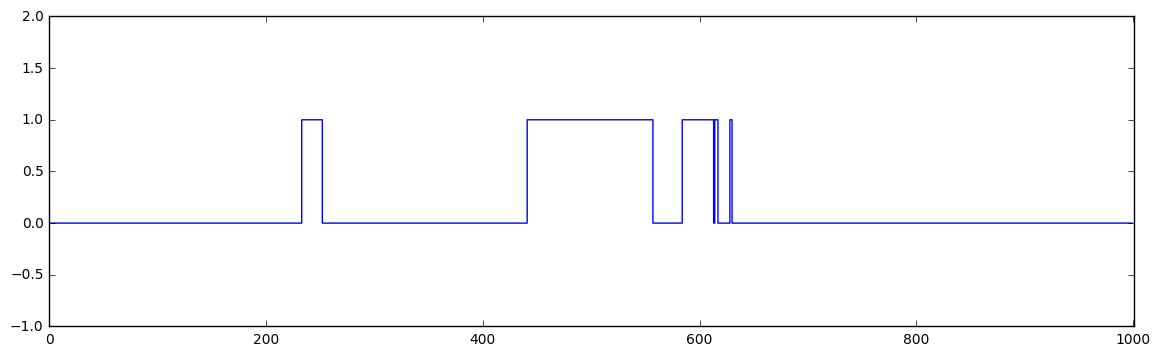

In [133]:
fig, ax = plt.subplots(1,1,figsize=(14,4))
x = np.arange(1000)
im = ax.step(x, y)
plt.axis([0, 1001 , -1, 2])